# ML Aproach To A Binary Classificaion of A Text Dataset

#### In this notebook I explained how to train machine learning models on a classification task with a text dataset. I used two models as Logistic Regression and Multinomial Naive Bayes with two different vectorizers as countVectorizer and tfidfVectorizer. Whie CountVectorizer use the architecture of CBOW and skip-gram methods TfidfVectorizer use Tfidf method of vectorization. Let's dive into the model construction!

# 1. Data Analysis

## Dependencies

In [2]:
# for feature engineering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec
#for word cloud
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Preprocessing and Getting to know the dataset

In [3]:
# Load the datasets
df_train = pd.read_csv('/workspaces/codespaces-jupyter/train.csv')
df_test = pd.read_csv('/workspaces/codespaces-jupyter/test.csv')
print(df_train.head())
print(df_test.head())



   Unnamed: 0                                            content  cyber_label  \
0           0  All rights reserved. MA23-16258 988982046\n\nh...          NaN   
1           1  Revisiting our purpose and/or values statement...          NaN   
2           2  Amid ongoing strategic competition in a\nmulti...          NaN   
3           3  Source: PwC Pulse Survey, November 2, 2022: ba...          NaN   
4           4  Executive Summary 2\nAgeing and\nHealth Conce...          NaN   

   environmental_issue  
0                    0  
1                    0  
2                    0  
3                    0  
4                    1  
   Unnamed: 0                                            content
0           0  More recently there has been a focus on risks ...
1           1  Energy crisis ↑\n3. Business interruption ↓\n\...
2           2  The survey results indicate that a lack of ski...
3           3  Respondents could\nselect more than one risk.0...
4           4  The interest payable on

In [4]:
#check all the columns: 4 columns: 3 columns numeric and 1 column object type.
df_train.columns 

Index(['Unnamed: 0', 'content', 'cyber_label', 'environmental_issue'], dtype='object')

In [5]:
# Let's check the info and missing values: The column 'cyber_label' has 1173 missing values out of 1300.
df_train.info() 
df_train.isnull().sum() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           1300 non-null   int64  
 1   content              1300 non-null   object 
 2   cyber_label          127 non-null    float64
 3   environmental_issue  1300 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 40.8+ KB


Unnamed: 0                0
content                   0
cyber_label            1173
environmental_issue       0
dtype: int64

In [6]:
 # Check only the values with cyber_label is 1.0 and compare them with environmental_issue 
df_train[df_train.loc[:,'cyber_label']==1]

,Unnamed: 0,content,cyber_label,environmental_issue
12,12,"As online\ncommunication became the norm, one ...",1.0,0
14,14,In comparing\n\nthis year’s survey results to ...,1.0,1
27,27,While the drive to have more\nefficient proces...,1.0,0
33,33,Risk in Focus 2023 roundtable participants\nag...,1.0,0
34,34,The list of ESG issues companies face is fueli...,1.0,1
...,...,...,...,...
1270,1270,", artificial intelligence, automation in all o...",1.0,0
1277,1277,"For example, advances in biotechnologies could...",1.0,0
1282,1282,They\nshould explain how much money their\norg...,1.0,0
1286,1286,“Most cyber incidents in the SME sector are ra...,1.0,0


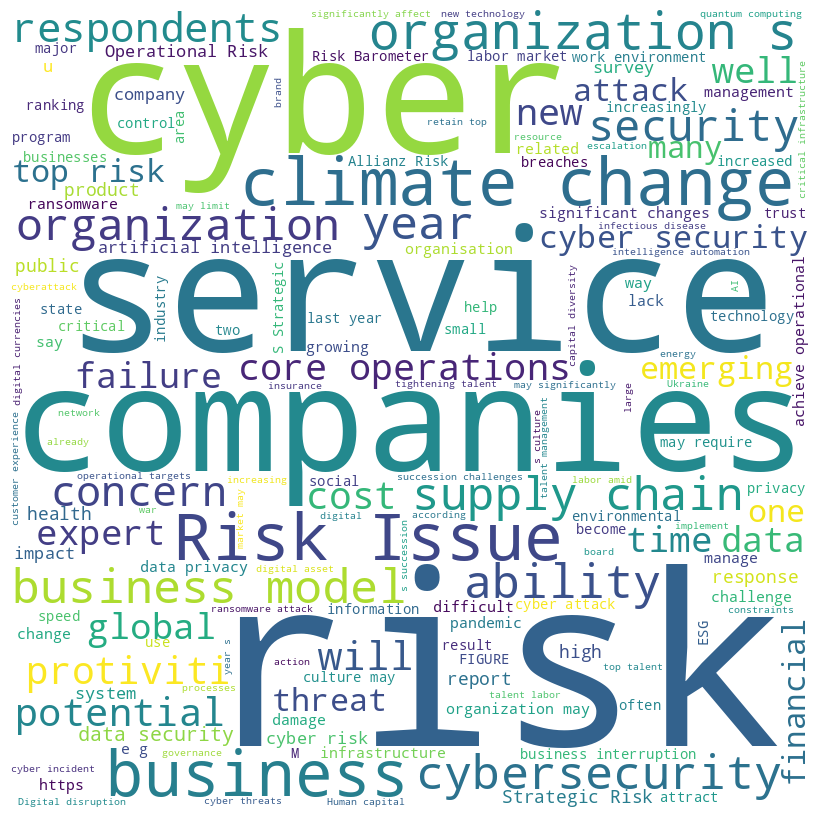

In [9]:
# Let's see the most frequent words in the 'content' grouped by cyber_label=1 by wordcloud.
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(''.join(i for i in df_train[df_train['cyber_label']==1]['content']))
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [10]:
# Check the stats of the numerical features.
df_train.describe() 

,Unnamed: 0,cyber_label,environmental_issue
count,1300.000000,127.0,1300.000000
mean,649.500000,1.0,0.218462
std,375.421985,0.0,0.413361
min,0.000000,1.0,0.000000
25%,324.750000,1.0,0.000000
50%,649.500000,1.0,0.000000
75%,974.250000,1.0,0.000000
max,1299.000000,1.0,1.000000


In [11]:
#check the distibution of the values of the column 'environmental_issue'
df_train.environmental_issue.value_counts() 

0    1016
1     284
Name: environmental_issue, dtype: int64

<Axes: >

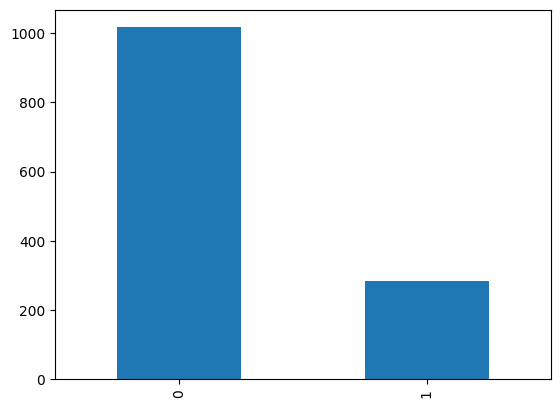

In [12]:
 #visualize the dist. of the values.
df_train['environmental_issue'].value_counts().plot(kind = 'bar')

## Preprocessing Pipeline

In [13]:
#nltk text preprocessing
# create preprocess_text function
def preprocess_text(text):
    r = re.sub('[^a-zA-Z]', ' ', text)
    # Tokenize the text
    tokens = word_tokenize(r.lower())
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text
# apply the function df_train and df_test
df_train['content'] = df_train['content'].apply(preprocess_text)
df_test['content'] = df_test['content'].apply(preprocess_text)
print(df_train.head())

   Unnamed: 0                                            content  cyber_label  \
0           0          right reserved http www marshmclennan com          NaN   
1           1  revisiting purpose value statement refining co...          NaN   
2           2  amid ongoing strategic competition multi polar...          NaN   
3           3  source pwc pulse survey november base cmo base...          NaN   
4           4  executive summary ageing health concern econom...          NaN   

   environmental_issue  
0                    0  
1                    0  
2                    0  
3                    0  
4                    1  


### Word Count

In [14]:
# Word count in each class groupby the target : Class positive has slightly more words in average
df_train['word_count'] = df_train['content'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['environmental_issue']==1]['word_count'].mean()) #risk
print(df_train[df_train['environmental_issue']==0]['word_count'].mean()) #Non-risk

124.69718309859155
107.50393700787401


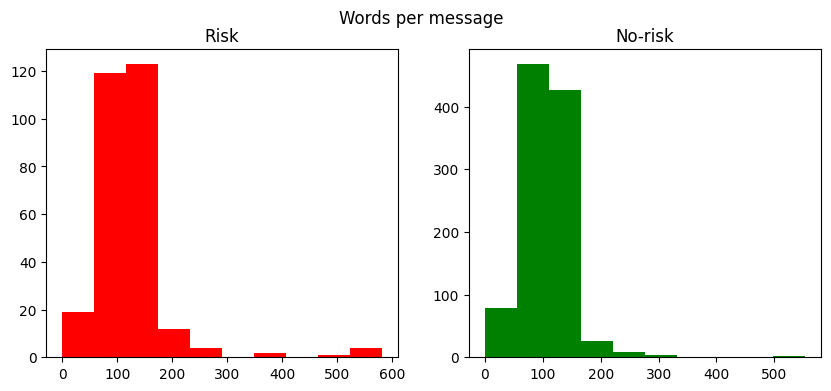

In [15]:
# Plotting the distribution of word count
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['environmental_issue']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Risk')
train_words=df_train[df_train['environmental_issue']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('No-risk')
fig.suptitle('Words per message')
plt.show()

### WordCloud for the frequent words groupby environmental_issue

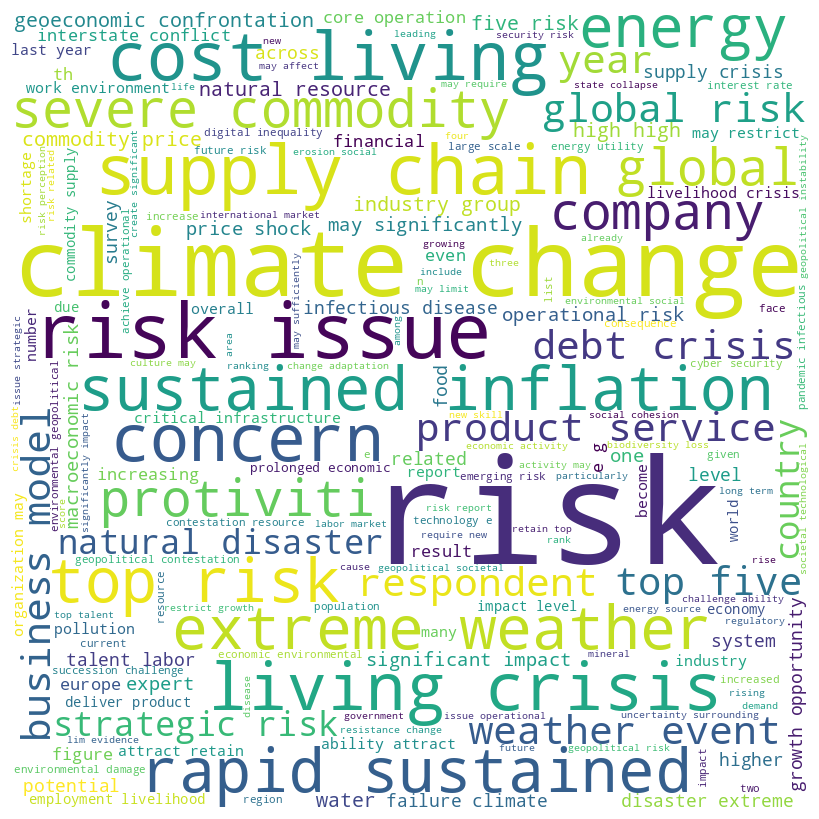

In [16]:
# Let's see the most frequent words in the 'content' by wordcloud in Risky messages.
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(''.join(i for i in df_train[df_train['environmental_issue']==1]['content']))
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

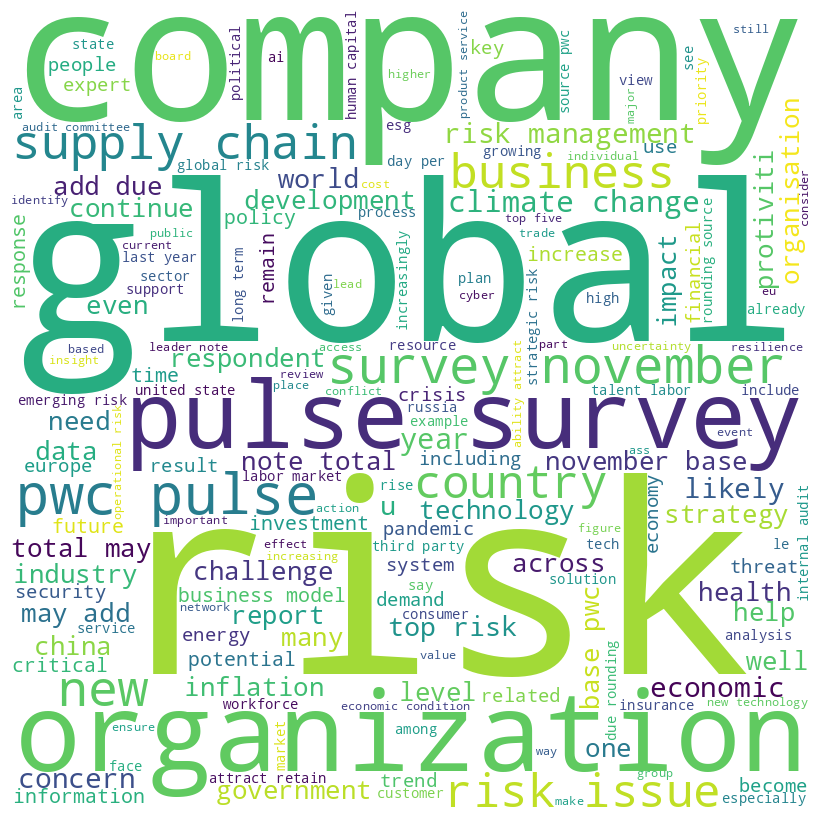

In [17]:
# Let's see the most frequent words in the 'content' by wordcloud in Non-Risky messages.
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(''.join(i for i in df_train[df_train['environmental_issue']==0]['content']))
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# 2. Machine Learning Models

In [18]:
# Create Feature and Label sets
X = df_train['content']
y = df_train['environmental_issue']
# train test split (80% train - 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print('Training Data :', X_train.shape)
print('Testing Data : ', X_test.shape)

Training Data : (1040,)
Testing Data :  (260,)


## Ferature Extraction

### CountVectorizer vs Tfidf Vectorizer

In [19]:
# Train Bag of Words model
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_train_cv.shape

(1040, 9331)

In [20]:
# Tfidf Vectorizer
tfidf = TfidfVectorizer() 
X_train_tfidf = tfidf.fit_transform(X_train)
X_train_tfidf.shape

(1040, 9331)

## Logistic Regression

In [21]:
lr_tfidf = make_pipeline(TfidfVectorizer(), LogisticRegression(solver = 'saga', C=10, penalty = 'l1'))
lr_count = make_pipeline(CountVectorizer(), LogisticRegression(solver = 'saga', C=10, penalty = 'l1'))

lr_tfidf.fit(X_train, y_train)
lr_count.fit(X_train, y_train)

(Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                 ('multinomialnb', LogisticRegression(solver = 'saga', C=10, penalty = 'l1'))]),
 Pipeline(steps=[('countvectorizer', CountVectorizer()),
                 ('multinomialnb', LogisticRegression(solver = 'saga', C=10, penalty = 'l1'))]))

y_pred_tfidf = lr_tfidf.predict(X_test)
y_pred_count = lr_count.predict(X_test)

f1_tfidf = f1_score(y_test, y_pred_tfidf, average='weighted')
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
print('Logistic Regression with TF-IDF:')
print('-' * 40)
print(f'f1: {f1_tfidf:.4f}')
print(f'accuracy: {accuracy_tfidf:.4f}')

f1_cv = f1_score(y_test, y_pred_count, average='weighted')
accuracy_cv = accuracy_score(y_test, y_pred_count)
print('Logistic Regression with count:')
print('-' * 40)
print(f'f1: {f1_cv:.4f}')
print(f'accuracy: {accuracy_cv:.4f}')

#generate the labels for the test dataset 
pred_lr_cv = lr_count.predict(df_test['content'])
pred_lr_tfidf = lr_tfidf.predict(df_test['content'])
print(pred_lr_cv)
print(pred_lr_tfidf)

df_test['lr_count'] = pred_lr_cv
df_test['lr_tfidf'] = pred_lr_tfidf
df_test.head()

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression with TF-IDF:
----------------------------------------
f1: 0.8722
accuracy: 0.8808
Logistic Regression with count:
----------------------------------------
f1: 0.8872
accuracy: 0.8923
[1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,Unnamed: 0,content,lr_count,lr_tfidf
0,0,recently focus risk pollution plastic litter d...,1,1
1,1,energy crisis business interruption impact ene...,1,0
2,2,survey result indicate lack skilled talent ava...,0,0
3,3,respondent could select one risk developing al...,0,0
4,4,interest payable country public debt expected ...,0,0


In [22]:
# confusion matrix for cv

from sklearn import metrics
df_cv = pd.DataFrame(metrics.confusion_matrix(y_test,y_pred_count), index=['pos','neg'], columns=['pos','neg'])
df_cv

,pos,neg
pos,197,8
neg,20,35


In [23]:
# confusion matrix for tfidf

from sklearn import metrics
df_tfidf = pd.DataFrame(metrics.confusion_matrix(y_test,y_pred_tfidf), index=['pos','neg'], columns=['pos','neg'])
df_tfidf

,pos,neg
pos,198,7
neg,24,31


In [24]:
# CountVectorizer has higher accuracy than Tfidf Vectorizer 
print(classification_report(y_test, y_pred_count)) 
print(classification_report(y_test, y_pred_tfidf))



              precision    recall  f1-score   support

           0       0.91      0.96      0.93       205
           1       0.81      0.64      0.71        55

    accuracy                           0.89       260
   macro avg       0.86      0.80      0.82       260
weighted avg       0.89      0.89      0.89       260

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       205
           1       0.82      0.56      0.67        55

    accuracy                           0.88       260
   macro avg       0.85      0.76      0.80       260
weighted avg       0.88      0.88      0.87       260



### Grid Search for the best parameters

In [25]:
# Grid search cross validation for the Best Parameters
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
lr = LogisticRegression(solver = 'saga', C=10, penalty = 'l1')
lr_cv = lr.fit(X_train_cv, y_train)
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]



grid_search = GridSearchCV(estimator = lr,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           verbose=0)


grid_search.fit(X_train_cv, y_train)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linea

GridSearchCV(cv=10,
             estimator=LogisticRegression(C=10, penalty='l1', solver='saga'),
             param_grid=[{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']},
                         {'penalty': ['none', 'elasticnet', 'l1', 'l2']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100]}],
             scoring='accuracy')

LogisticRegression(C=10, penalty='l1', solver='saga') is the best parameter

In [26]:
# Grid search cross validation for the Best Parameters
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
grid_search.fit(X_train_tfidf, y_train)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linea

GridSearchCV(cv=10,
             estimator=LogisticRegression(C=10, penalty='l1', solver='saga'),
             param_grid=[{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']},
                         {'penalty': ['none', 'elasticnet', 'l1', 'l2']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100]}],
             scoring='accuracy')

## Naive Bayes Model

In [27]:
model_tfidf = make_pipeline(TfidfVectorizer(), MultinomialNB())
model_count = make_pipeline(CountVectorizer(), MultinomialNB())

model_tfidf.fit(X_train, y_train), \
model_count.fit(X_train, y_train)

(Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                 ('multinomialnb', MultinomialNB())]),
 Pipeline(steps=[('countvectorizer', CountVectorizer()),
                 ('multinomialnb', MultinomialNB())]))

y_pred_tfidf = model_tfidf.predict(X_test)
y_pred_count = model_count.predict(X_test)

f1_tfidf = f1_score(y_test, y_pred_tfidf, average='weighted')
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
print('Multinomial Naive Bayes with TF-IDF:')
print('-' * 40)
print(f'f1: {f1_tfidf:.4f}')
print(f'accuracy: {accuracy_tfidf:.4f}')

f1_cv = f1_score(y_test, y_pred_count, average='weighted')
accuracy_cv = accuracy_score(y_test, y_pred_count)
print('Multinomial Naive Bayes with Count:')
print('-' * 40)
print(f'f1: {f1_cv:.4f}')
print(f'accuracy: {accuracy_cv:.4f}')

Multinomial Naive Bayes with TF-IDF:
----------------------------------------
f1: 0.7216
accuracy: 0.8000
Multinomial Naive Bayes with Count:
----------------------------------------
f1: 0.8692
accuracy: 0.8692


In [28]:
# CountVectorizer has higher accuracy than Tfidf Vectorizer 
print(classification_report(y_test, y_pred_count)) 
print(classification_report(y_test, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       205
           1       0.69      0.69      0.69        55

    accuracy                           0.87       260
   macro avg       0.80      0.80      0.80       260
weighted avg       0.87      0.87      0.87       260

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       205
           1       1.00      0.05      0.10        55

    accuracy                           0.80       260
   macro avg       0.90      0.53      0.50       260
weighted avg       0.84      0.80      0.72       260



In [29]:
# confusion matrix for cv

from sklearn import metrics
df_cv = pd.DataFrame(metrics.confusion_matrix(y_test,y_pred_count), index=['pos','neg'], columns=['pos','neg'])
df_cv

,pos,neg
pos,188,17
neg,17,38


In [30]:
# confusion matrix for tfidf

from sklearn import metrics
df_tfidf = pd.DataFrame(metrics.confusion_matrix(y_test,y_pred_tfidf), index=['pos','neg'], columns=['pos','neg'])
df_tfidf

,pos,neg
pos,205,0
neg,52,3


## Conclusion

In [31]:
df_test.to_csv('test_labelled.csv')

### Among the 4 variations of 2 models Decision Tree with CountVectorizer gives the highest accuracy as almost %90. But all the models performed close to each other. 